In [2]:
# Libraries

import pandas as pd
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from skimage import io
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
imageDataset = 'DataFix'

paths = [path.parts[-2:] for path in
         Path(imageDataset).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row
df 

In [ ]:
totalImage = len(df.Images)
totalClass = len(df['Class'].value_counts())

print("Total Image : {}" .format(totalImage))
print("Total Class : {}" .format(totalClass))

print('Number of images in each class : ')
print(df['Class'].value_counts().sort_index())

In [ ]:
# Getting size of all images

def getImageSizes(dataset_path):
    # Iterate over all folders in the dataset directory
    for alphabet_folder in os.listdir(dataset_path):
        alphabet_folder_path = os.path.join(dataset_path, alphabet_folder)
        
        # Check if the current path is a directory
        if os.path.isdir(alphabet_folder_path):
            print(f"Alphabet folder: {alphabet_folder}")
            
            # Iterate over all files in the current alphabet folder
            for filename in os.listdir(alphabet_folder_path):
                file_path = os.path.join(alphabet_folder_path, filename)
                
                # Check if the file is an image
                if filename.lower().endswith(('.jpg')):
                    try:
                        # Open the image
                        with Image.open(file_path) as img:
                            # Print the image size
                            print(f"    {filename}: {img.size}")
                    except Exception as e:
                        print(f"    Could not open image {filename}: {e}")


getImageSizes(imageDataset)


In [ ]:
# Count the image that has same sizes

def storeImageSize(dataset_path):
    image_sizes = []

    # Iterate over all folders in the dataset directory
    for alphabet_folder in os.listdir(dataset_path):
        alphabet_folder_path = os.path.join(dataset_path, alphabet_folder)
        
        # Check if the current path is a directory
        if os.path.isdir(alphabet_folder_path):
            # Iterate over all files in the current alphabet folder
            for filename in os.listdir(alphabet_folder_path):
                file_path = os.path.join(alphabet_folder_path, filename)
                
                # Check if the file is an image
                if filename.lower().endswith(('.jpg')):
                    try:
                        # Open the image
                        with Image.open(file_path) as img:
                            # Append the image size to the list
                            image_sizes.append(img.size)
                    except Exception as e:
                        print(f"Could not open image {filename}: {e}")
    return image_sizes

def countsImageSize(image_sizes):
    # Count the occurrences of each image size
    size_counts = Counter(image_sizes)
    
    # Extract the sizes and their counts
    sizes = list(size_counts.keys())
    counts = list(size_counts.values())
    
    # Convert sizes to string format for better readability in the plot
    sizes_str = [f"{size[0]}x{size[1]}" for size in sizes]
    
    # Plot the image size counts
    # plt.figure(figsize=(14, 7))
    # plt.bar(sizes_str, counts, alpha=0.6, color='blue')
    # plt.title("Image Size Counts")
    # plt.xlabel("Image Size (width x height)")
    # plt.ylabel("Number of Images")
    # plt.xticks(rotation=90)
    # plt.tight_layout()
    # plt.show()
    
    # Create a DataFrame for the table
    df = pd.DataFrame({
        'Image Size (width x height)': sizes_str,
        'Number of Images': counts
    })
    
    df = df.sort_values(by='Number of Images', ascending=False)
    
    # Print the table
    print(df)


# Get image sizes
image_sizes = storeImageSize(imageDataset)

# Plot image size counts and display the table
countsImageSize(image_sizes)


In [ ]:
# Display sample image for each letter

def displaySampleImage(root_folder):
    # Create a list to store image paths
    image_paths = []
    letters = []

    # Iterate over all alphabet folders in the root folder
    for letter_folder in sorted(os.listdir(root_folder)):
        letter_path = os.path.join(root_folder, letter_folder)
        
        if os.path.isdir(letter_path):
            # Get a list of all image files in the folder
            image_files = sorted([
                f for f in os.listdir(letter_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
            ])
            
            if image_files:
                # Select the first image in the folder
                first_image = image_files[0]
                image_paths.append(os.path.join(letter_path, first_image))
                letters.append(letter_folder)
    
    # Calculate the number of rows and columns for the plot
    num_images = len(image_paths)
    cols = 4
    rows = (num_images // cols) + (1 if num_images % cols != 0 else 0)
    
    # Create a figure to display the images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    # Display each image
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(letters[i])
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Display one image per letter
displaySampleImage(imageDataset)

In [ ]:
# Resize image dataset and make a new directory

def resizeImage(root_folder, target_folder, size=(128, 128)):
    # Supported image formats
    supported_formats = ('.png', '.jpg', '.jpeg', '.gif', '.bmp')

    # Iterate over all folders and files in the root folder recursively
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(supported_formats):
                # Construct full file path
                file_path = os.path.join(root, file)
                
                # Determine the relative path inside the root folder
                relative_path = os.path.relpath(root, root_folder)
                
                # Construct target folder path
                target_subfolder = os.path.join(target_folder, relative_path)
                if not os.path.exists(target_subfolder):
                    os.makedirs(target_subfolder)
                
                # Open the image
                with Image.open(file_path) as img:
                    # Resize the image
                    resized_img = img.resize(size, Image.ANTIALIAS)
                    
                    # Construct target file path
                    target_file_path = os.path.join(target_subfolder, file)
                    
                    # Save the resized image
                    resized_img.save(target_file_path)

                #print(f"Resized and saved {file_path} to {target_file_path}")

# Path to the root folder containing images
root_folder = 'E:\Bangkit\Capstone\Code\DataFix'

# Path to the target folder to save resized images
target_folder = 'ResizedData'

# Resize images to 128x128 and save them with the same folder structure
resizeImage(root_folder, target_folder, size=(128, 128))


In [ ]:
resizedData = r'E:\Bangkit\Capstone\Code\ResizedData'
# Get image sizes
resizedImage = storeImageSize(resizedData)

# Plot image size counts and display the table
countsImageSize(resizedImage)

In [ ]:
resizedData = r'E:\Bangkit\Capstone\Code\ResizedData'
displaySampleImage(resizedData)

In [3]:
def create_directories(base_path, categories):
    for category in categories:
        os.makedirs(os.path.join(base_path, category), exist_ok=True)

def split_data(input_directory, output_directory, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Define the directories for train, validation, and test sets
    train_dir = os.path.join(output_directory, 'train')
    val_dir = os.path.join(output_directory, 'val')
    test_dir = os.path.join(output_directory, 'test')

    # Create the train, validation, and test directories
    create_directories(output_directory, ['train', 'val', 'test'])
    
    # Iterate through the alphabetically named subdirectories
    for subdir in sorted(os.listdir(input_directory)):
        subdir_path = os.path.join(input_directory, subdir)
        
        # Ensure it's a directory
        if os.path.isdir(subdir_path):
            # Get list of all files in the subdirectory
            all_files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            random.shuffle(all_files)
            
            # Calculate the number of files for each set
            total_files = len(all_files)
            train_count = int(total_files * train_ratio)
            val_count = int(total_files * val_ratio)
            test_count = total_files - train_count - val_count
            
            # Split the files
            train_files = all_files[:train_count]
            val_files = all_files[train_count:train_count + val_count]
            test_files = all_files[train_count + val_count:]
            
            # Define subdirectories for current letter in each set
            train_subdir = os.path.join(train_dir, subdir)
            val_subdir = os.path.join(val_dir, subdir)
            test_subdir = os.path.join(test_dir, subdir)
            
            # Create these subdirectories
            os.makedirs(train_subdir, exist_ok=True)
            os.makedirs(val_subdir, exist_ok=True)
            os.makedirs(test_subdir, exist_ok=True)
            
            # Copy files to respective directories
            for file_name in train_files:
                shutil.copy(os.path.join(subdir_path, file_name), os.path.join(train_subdir, file_name))
            for file_name in val_files:
                shutil.copy(os.path.join(subdir_path, file_name), os.path.join(val_subdir, file_name))
            for file_name in test_files:
                shutil.copy(os.path.join(subdir_path, file_name), os.path.join(test_subdir, file_name))

# Example usage
input_directory = 'GrayScale'  # The directory containing grayscale images
output_directory = 'SplitData'  # The directory to save split data
split_data(input_directory, output_directory)


In [4]:
trainDataset = 'SplitData/train'
testDataset = 'SplitData/test'

paths = [path.parts[-2:] for path in
         Path(trainDataset).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row

totalImage = len(df.Images)
totalClass = len(df['Class'].value_counts())

print("Total Image : {}" .format(totalImage))
print("Total Class : {}" .format(totalClass))

# print('Number of images in each class : ')
# print(df['Class'].value_counts().sort_index())

Total Image : 4732
Total Class : 26


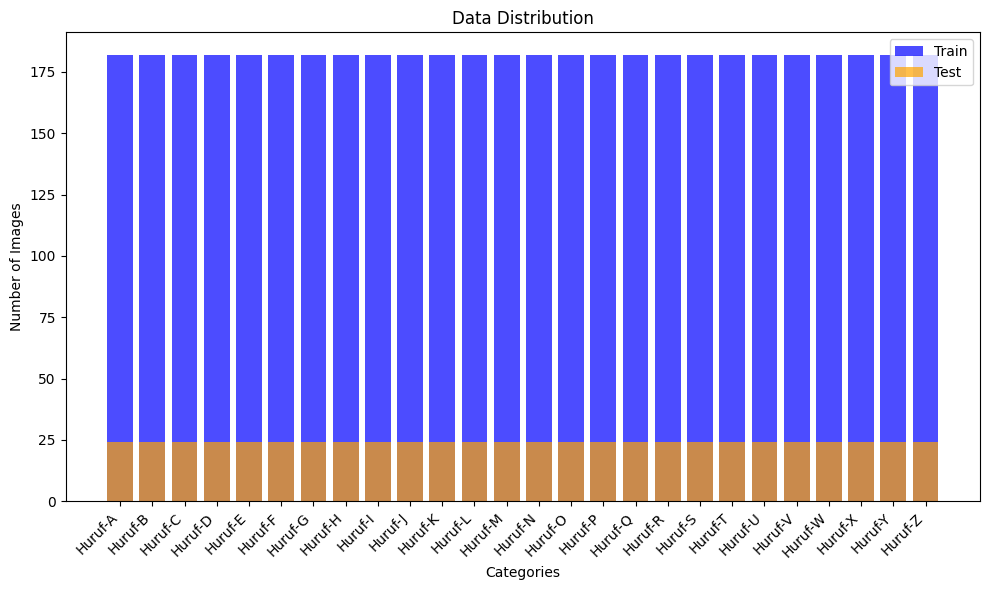

In [5]:
# Get the list of categories (folder names)
categories = os.listdir(trainDataset)

# Count the number of images in each category for both train and test sets
train_counts = []
test_counts = []
for category in categories:
    train_count = len(os.listdir(os.path.join(trainDataset, category)))
    test_count = len(os.listdir(os.path.join(testDataset, category)))
    train_counts.append(train_count)
    test_counts.append(test_count)

# Plotting the data distribution
plt.figure(figsize=(10, 6))
plt.bar(categories, train_counts, color='blue', alpha=0.7, label='Train')
plt.bar(categories, test_counts, color='orange', alpha=0.7, label='Test')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Data Distribution')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# ImageDataGenerator
traindir = 'SplitData/train'
testdir = 'SplitData/test'

training_datagen = ImageDataGenerator(
        rescale = 1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	traindir,
	target_size=(128,128),
	class_mode='categorical',
  batch_size=128
)

test_generator = test_datagen.flow_from_directory(
	testdir,
	target_size=(128,128),
	class_mode='categorical',
  batch_size=128
)

Found 4732 images belonging to 26 classes.
Found 624 images belonging to 26 classes.


In [10]:
# Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(26, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)      

In [11]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, epochs=100, validation_data = test_generator, verbose=1)

Epoch 1/100
37/37 [==============================] - 35s 902ms/step - loss: 3.2593 - accuracy: 0.0323 - val_loss: 3.2581 - val_accuracy: 0.0385
Epoch 2/100
37/37 [==============================] - 37s 1s/step - loss: 3.2381 - accuracy: 0.0530 - val_loss: 3.1154 - val_accuracy: 0.0897
Epoch 3/100
37/37 [==============================] - 34s 905ms/step - loss: 3.0147 - accuracy: 0.1067 - val_loss: 2.6846 - val_accuracy: 0.1779
Epoch 4/100
37/37 [==============================] - 34s 910ms/step - loss: 2.6575 - accuracy: 0.1913 - val_loss: 2.0414 - val_accuracy: 0.3782
Epoch 5/100
37/37 [==============================] - 33s 892ms/step - loss: 2.2558 - accuracy: 0.2973 - val_loss: 1.6281 - val_accuracy: 0.5128
Epoch 6/100
37/37 [==============================] - 33s 886ms/step - loss: 1.8076 - accuracy: 0.4434 - val_loss: 1.1630 - val_accuracy: 0.6619
Epoch 7/100
37/37 [==============================] - 33s 893ms/step - loss: 1.4582 - accuracy: 0.5437 - val_loss: 0.9282 - val_accuracy: 0.

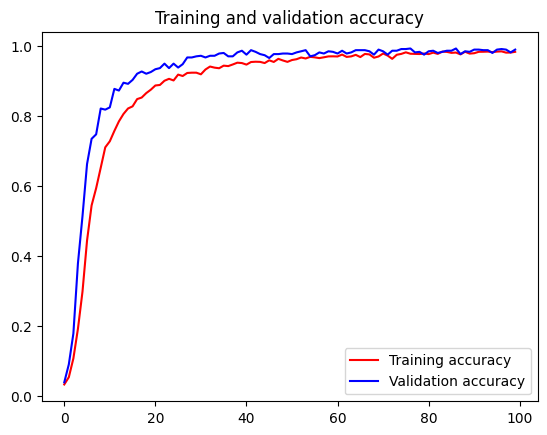

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [15]:
valdir = 'SplitData/val'
datagen = ImageDataGenerator(rescale= 1.0 / 255)
valdata = datagen.flow_from_directory(directory= valdir, 
                                         target_size=(128, 128), 
                                         batch_size = 128, 
                                         class_mode='categorical',
                                         shuffle= False)

Found 572 images belonging to 26 classes.


In [17]:
import numpy as np
# prediction
result = model.predict(valdata,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = valdata.labels

# Evaluvate
loss,acc = model.evaluate(valdata,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 99.47552680969238
The Loss of the model for testing data is: 0.02002820372581482


In [18]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 569
Incorrect predicted classes: 3


In [22]:
predictions = np.argmax(result, axis = 1)
predictions

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 10

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(valdata.classes, predictions)

0.9947552447552448

In [24]:
from sklearn.metrics import classification_report
print(classification_report(valdata.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        22
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        22
          11       1.00      1.00      1.00        22
          12       0.96      1.00      0.98        22
          13       1.00      0.95      0.98        22
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        22
          16       1.00      1.00      1.00        22
          17       1.00    

<AxesSubplot: >

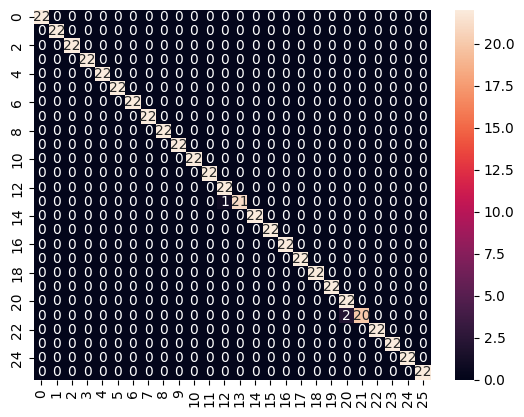

In [25]:
import seaborn as sns
from sklearn.metrics import accuracy_score
accuracy_score(valdata.classes, predictions)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valdata.classes, predictions)
sns.heatmap(cm, annot=True)

In [30]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array


# Specify the directory containing your images
exampleImage = r'E:\Bangkit\Capstone\Code\a.jpg'

img = load_img(exampleImage, target_size=(128, 128))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

print(f"{classes}")



1/1 [==============================] - 0s 129ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [27]:
model.save("modelFix.h5")